In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing import image
from tensorflow import data as tf_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-26 20:43:07.491768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:43:07.956749: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:43:07.958040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 20:43:10.079535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Define directories
train_dir = '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train'
test_dir = '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/test'

# Create data generators with rescaling
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 242 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [14]:
print("Class Indices:", test_generator.class_indices)

Class Indices: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

num_classes = 3

# Load the base model
base_model_path = '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/BaseModel'
base_model = load_model(base_model_path)

# Load the augmented model
augmented_model_path = '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/AugmentedModel'
augmented_model = load_model(augmented_model_path)

# Generate predictions using the test data for both models
base_model_predictions = base_model.predict(test_generator)
augmented_model_predictions = augmented_model.predict(test_generator)

2024-04-26 20:55:27.842869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 2s 215ms/step


2024-04-26 20:55:29.873007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 2s 239ms/step


In [21]:
# Get the true labels from the test generator
true_labels = test_generator.labels

# Check the shapes of the true labels and predictions
print("True labels shape:", true_labels.shape)
print("Base model predictions shape:", base_model_predictions.shape)
print("Augmented model predictions shape:", augmented_model_predictions.shape)


True labels shape: (63,)
Base model predictions shape: (63, 3)
Augmented model predictions shape: (63, 3)


In [23]:
from keras.utils import to_categorical

# Assuming true labels are loaded from your test generator
true_labels_categorical = to_categorical(true_labels, num_classes=3)

# Check the shape of the true labels array after conversion
print("True labels categorical shape:", true_labels_categorical.shape)

True labels categorical shape: (63, 3)


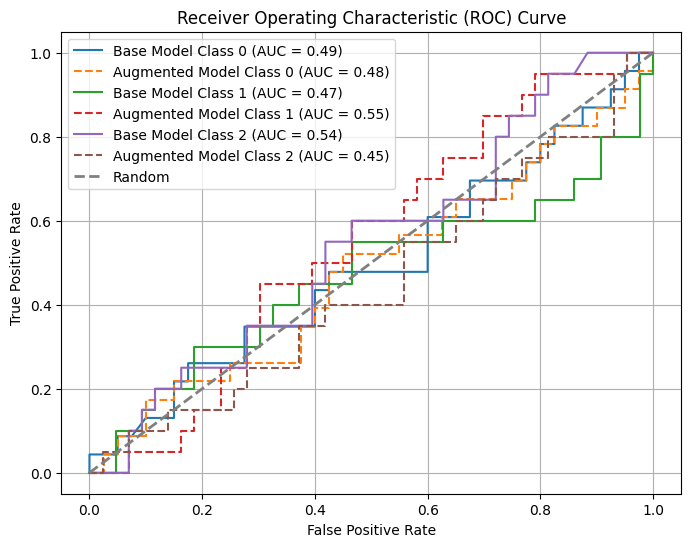

In [24]:
# Initialize lists to store ROC curve values and AUC for each class
base_fpr = []
base_tpr = []
base_auc = []
augmented_fpr = []
augmented_tpr = []
augmented_auc = []

# Compute ROC curve and AUC for each class
for i in range(3):  # Assuming 3 classes
    # Compute ROC curve and AUC
    base_fpr_i, base_tpr_i, _ = roc_curve(true_labels_categorical[:, i], base_model_predictions[:, i])
    base_auc_i = auc(base_fpr_i, base_tpr_i)
    base_fpr.append(base_fpr_i)
    base_tpr.append(base_tpr_i)
    base_auc.append(base_auc_i)
    
    augmented_fpr_i, augmented_tpr_i, _ = roc_curve(true_labels_categorical[:, i], augmented_model_predictions[:, i])
    augmented_auc_i = auc(augmented_fpr_i, augmented_tpr_i)
    augmented_fpr.append(augmented_fpr_i)
    augmented_tpr.append(augmented_tpr_i)
    augmented_auc.append(augmented_auc_i)

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(3):  # Assuming 3 classes
    plt.plot(base_fpr[i], base_tpr[i], label=f"Base Model Class {i} (AUC = {base_auc[i]:.2f})")
    plt.plot(augmented_fpr[i], augmented_tpr[i], linestyle='--', label=f"Augmented Model Class {i} (AUC = {augmented_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

**Base Model:**
- Class 0: AUC = 0.49 (Poor performance, slightly better than random guessing)
- Class 1: AUC = 0.47 (Poor performance, slightly better than random guessing)
- Class 2: AUC = 0.54 (Fair performance, slightly better than random guessing)

**Augmented Model:**
- Class 0: AUC = 0.48 (Poor performance, similar to the base model)
- Class 1: AUC = 0.55 (Fair performance, slightly better than the base model)
- Class 2: AUC = 0.45 (Poor performance, worse than the base model)

In general, the augmented model shows slightly improved performance for Class 1 compared to the base model, while the performance for Class 2 is slightly worse. Class 0 performance remains similar between the two models. However, overall, the performance for all classes is relatively poor, with AUC values close to or slightly better than random guessing (AUC = 0.5).